# SAW Movie Recommendation System

### Business Problem

WAS is a startup movie streaming service that needs a recommendation system for their users. Americans spend roughly 110 days of their lives browsing for something to watch. Our recommendation system is here to minimize that time so WAS users can watch more and browse less. 

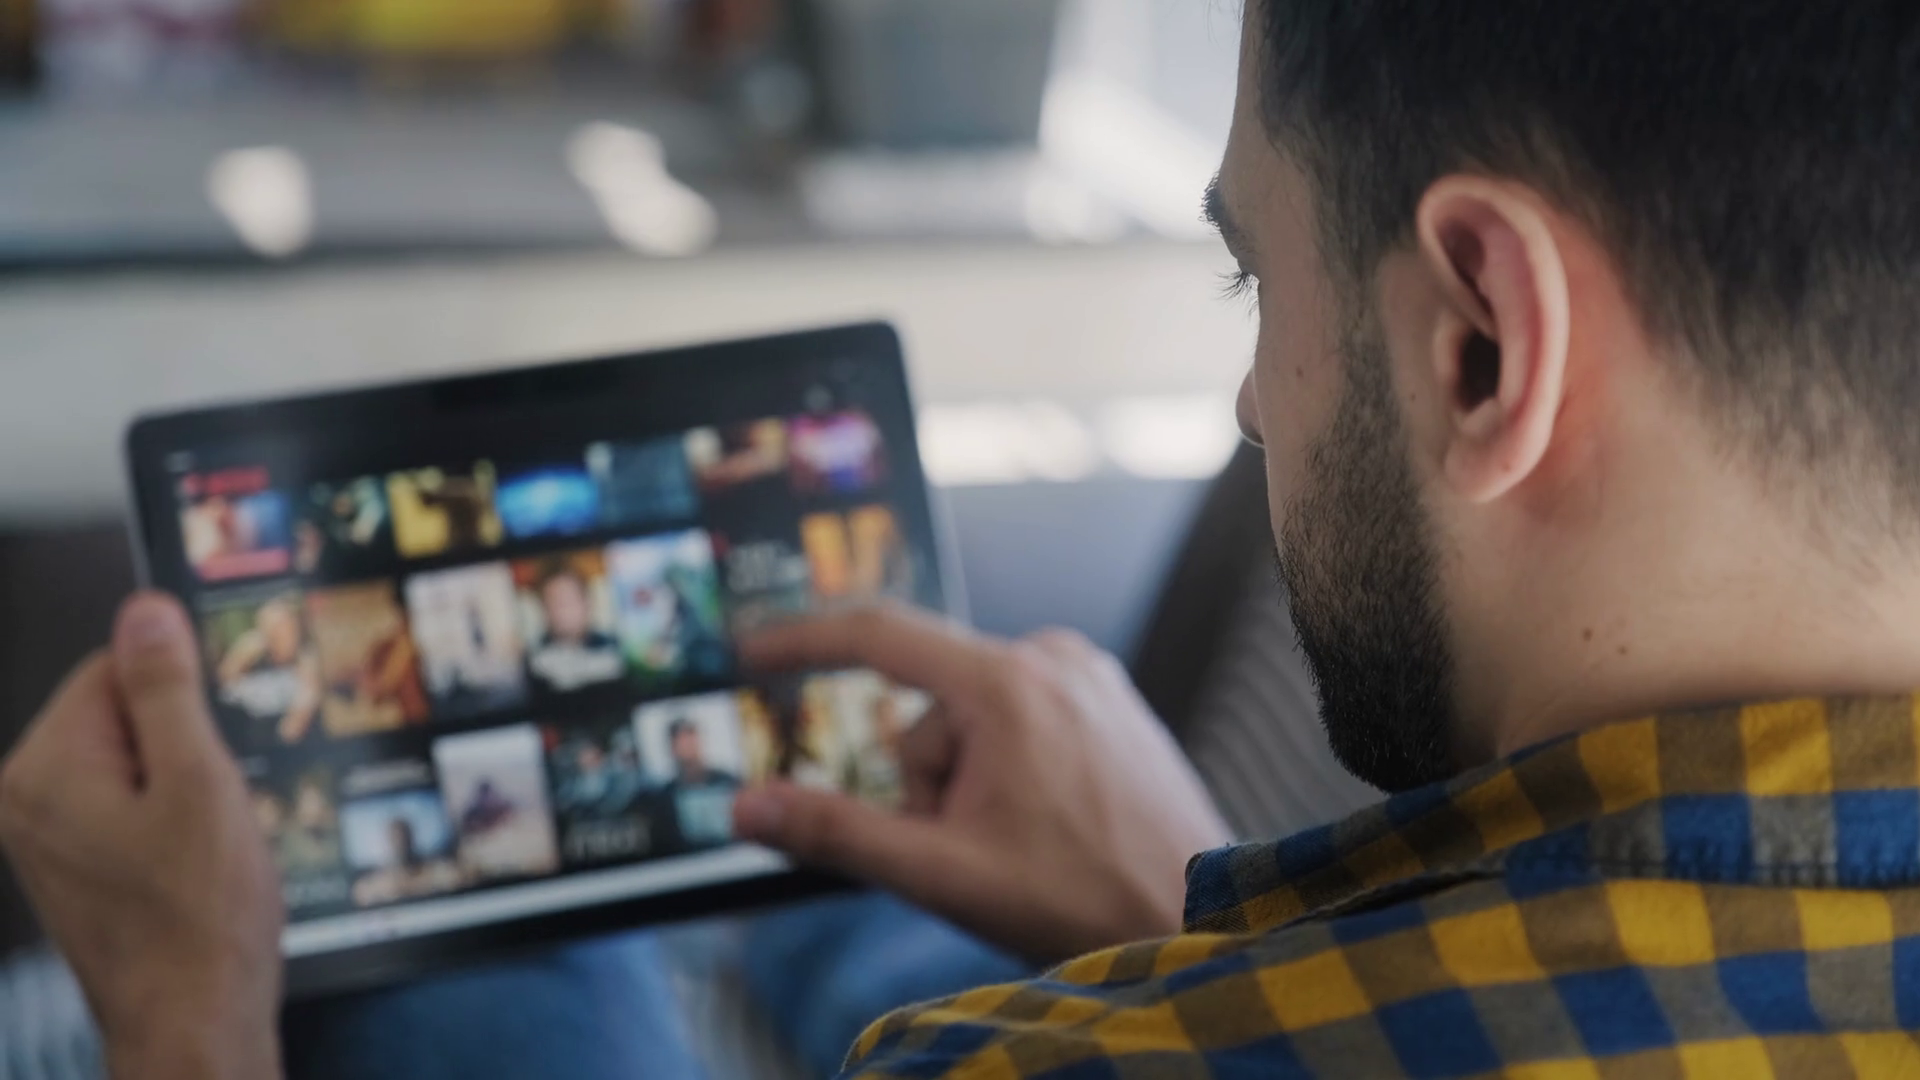

## EDAs and Data Exploration

In [23]:
import surprise
from surprise.prediction_algorithms import *
from surprise import accuracy
from surprise import Reader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import numpy as np
from collections import defaultdict
import datetime as dt
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [24]:
links_df = pd.read_csv('data/links.csv')
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

In [25]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [26]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [27]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [28]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [29]:
print(movies_df['movieId'].value_counts())


86014     1
1282      1
3347      1
1298      1
25870     1
         ..
60072     1
4775      1
50601     1
131749    1
83969     1
Name: movieId, Length: 9742, dtype: int64


In [30]:
print(ratings_df['movieId'].value_counts())


356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64


In [31]:
movie_ratings_df = pd.merge(ratings_df, movies_df[['movieId','title','genres']], on='movieId', how='left')

movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [32]:
movie_ratings_df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [33]:
movie_ratings_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object')

In [34]:
print(movie_ratings_df['userId'].value_counts())

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64


In [35]:
print(movie_ratings_df['movieId'].value_counts())

356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64


In [36]:
print(movie_ratings_df['movieId'].value_counts().sort_values())


8196        1
80083       1
78034       1
116941      1
96411       1
         ... 
2571      278
593       279
296       307
318       317
356       329
Name: movieId, Length: 9724, dtype: int64


In [37]:
print(movie_ratings_df['title'].value_counts().sort_values())

Philadelphia Experiment, The (1984)         1
United States of Leland, The (2003)         1
How to Make Love to a Woman (2010)          1
Kizumonogatari Part 1: Tekketsu (2016)      1
Acid House, The (1998)                      1
                                         ... 
Matrix, The (1999)                        278
Silence of the Lambs, The (1991)          279
Pulp Fiction (1994)                       307
Shawshank Redemption, The (1994)          317
Forrest Gump (1994)                       329
Name: title, Length: 9719, dtype: int64


## Data Visualizations

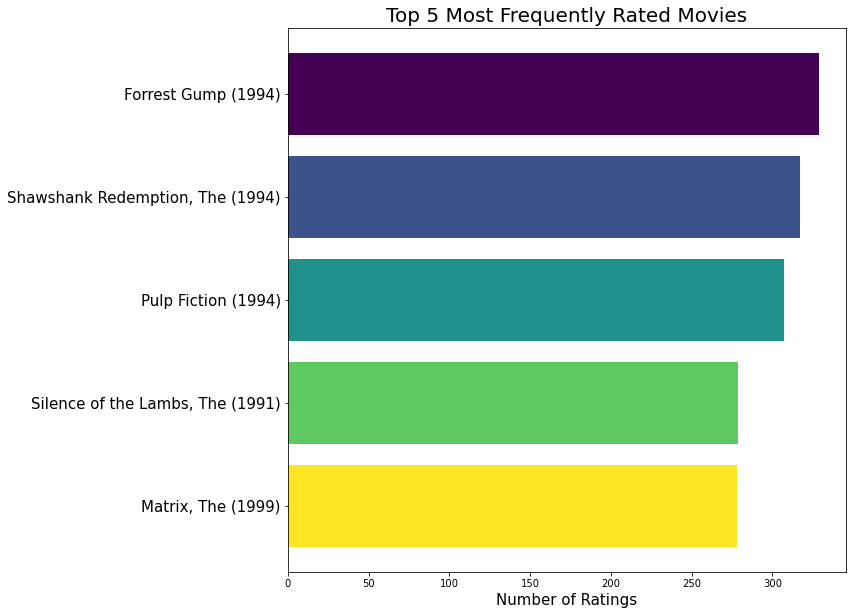

In [38]:
top_5_movies = movie_ratings_df['title'].value_counts().head(5)
top_5_movies

colors = cm.viridis(np.linspace(0, 1, len(top_5_movies)))

plt.figure(figsize=(10,10))
plt.barh(top_5_movies.index, top_5_movies.values, color=colors)
plt.xlabel('Number of Ratings', fontsize=15)
plt.title('Top 5 Most Frequently Rated Movies', fontsize=20)
plt.yticks(fontsize=15)
plt.gca().invert_yaxis() 
plt.show()

The chart above shows the top 5 movies which the highest number of total ratings in the dataset.

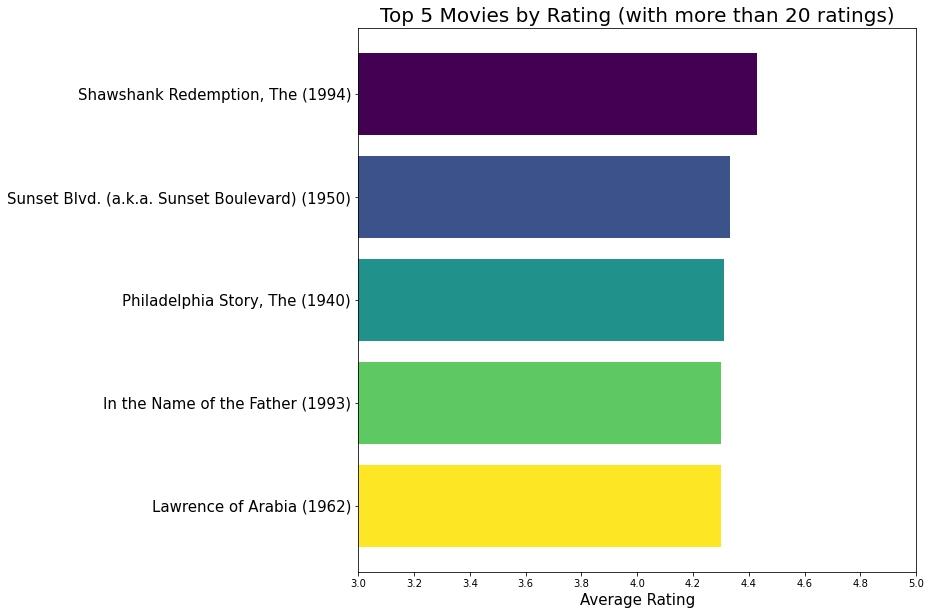

In [39]:
movie_stats = movie_ratings_df.groupby('title').agg({'rating': [np.size, np.mean]})
atleast_20 = movie_stats['rating']['size'] >= 25
movie_stats = movie_stats[atleast_20].sort_values([('rating', 'mean')], ascending=False)

top_5_movies = movie_stats.head(5)

colors = cm.viridis(np.linspace(0, 1, len(top_5_movies)))

plt.figure(figsize=(10,10))
plt.barh(top_5_movies.index, top_5_movies[('rating', 'mean')], color=colors)
plt.xlabel('Average Rating', fontsize=15)
plt.title('Top 5 Movies by Rating (with more than 20 ratings)', fontsize=20)
plt.yticks(fontsize=15)
plt.gca().invert_yaxis()  
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.xlim(3, 5)
plt.show()

The chart above shows the movies with the highest ratings, given that the movie been rated more than 20 times in the dataset. 

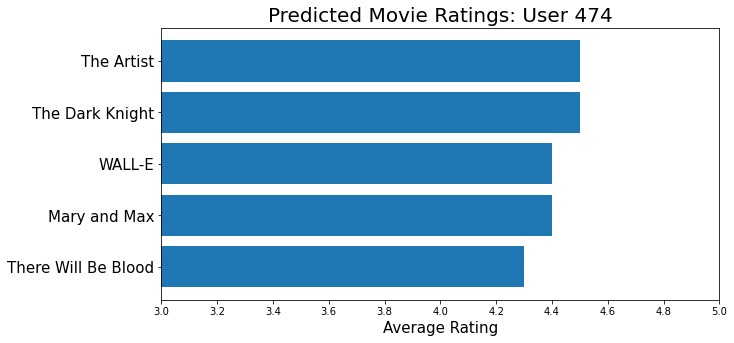

In [45]:
movies = ["The Artist", "The Dark Knight","WALL-E", "Mary and Max", "There Will Be Blood"]
ratings = [4.5, 4.5, 4.4, 4.4, 4.3]

plt.figure(figsize=(10,5))
plt.barh(movies, ratings)
plt.xlabel('Average Rating', fontsize=15)
plt.title('Predicted Movie Ratings: User 474', fontsize=20)
plt.yticks(fontsize=15)
plt.gca().invert_yaxis()  
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.xlim(3, 5)
plt.show()
plt.show()

The chart above shows the results of running UserID: 474 through our recommendation model. 

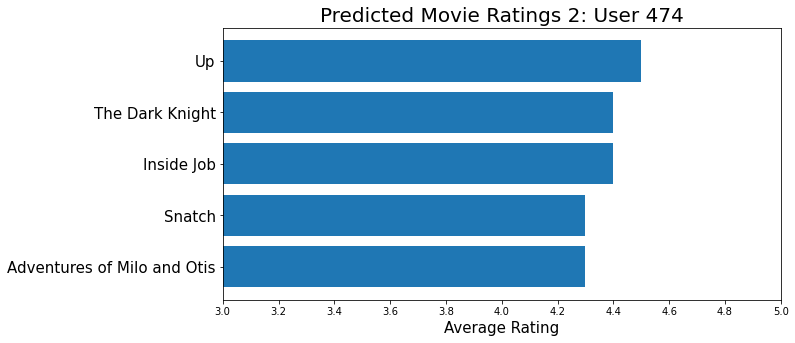

In [44]:
ratings2 = [4.5, 4.4, 4.4, 4.3, 4.3]
movies1 = ["Up", "The Dark Knight", "Inside Job","Snatch", "Adventures of Milo and Otis" ]

plt.figure(figsize=(10,5))
plt.barh(movies1, ratings2)
plt.xlabel('Average Rating', fontsize=15)
plt.title('Predicted Movie Ratings 2: User 474', fontsize=20)
plt.yticks(fontsize=15)
plt.gca().invert_yaxis()  
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.xlim(3, 5)
plt.show()
plt.show()

The chart above shows the results of running UserID: 474 through our recommendation model another time.

# Recommendation Model

In [20]:
df_merged = movie_ratings_df

In [21]:
reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(df_merged[['userId', 'movieId', 'rating']], reader)

trainset = data.build_full_trainset()

### Model Comparison

In [22]:
SVD_model = SVD().fit(trainset)
KNN_model = KNNBasic().fit(trainset)
NMF_model = NMF().fit(trainset)

testset = trainset.build_anti_testset()

SVD_RMSE = surprise.accuracy.rmse(SVD_model.test(testset))
SVD_MAE = surprise.accuracy.mae(SVD_model.test(testset))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4851
MAE:  0.3756


In [23]:
KNN_RMSE = surprise.accuracy.rmse(KNN_model.test(testset))
KNN_MAE = surprise.accuracy.mae(KNN_model.test(testset))

RMSE: 0.9030
MAE:  0.6743


In [24]:
NMF_RMSE = surprise.accuracy.rmse(NMF_model.test(testset))
NMF_MAE = surprise.accuracy.mae(NMF_model.test(testset))

RMSE: 1.0014
MAE:  0.7779


### Final Model

In [25]:
def get_top_n(predictions, n=5):

    # First we map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then we sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [26]:
best_model = SVD_model
# We declare SVD as our best model due to it's higher performance.

predictions = best_model.test(testset)
# We get our predictions. 

top_n = get_top_n(predictions, n=5)
# Get our top recommendations for each user and declare it equal to top_n

In [27]:
def top_five_rec1(userId):
    
    top_five_list = []
    for x in range(1):
        top_five_list.append(top_n[userId])
    return top_five_list
# We create a list and append the top 5 recommendation's ratings to it. 

In [28]:
def top_five_rec(userId):
    
    top_five_list = []
    for x in range(5):
        top_five_list.append(top_n[userId][x][0])
    
    for x in top_five_list:
        print(df_merged[df_merged['movieId'] == x]['title'].head(1))
# We create a list and append the top 5 recommendation's movie titles to it. 

In [29]:
top_five_rec1(474)
# We get our top 5 recommendation's ratings.

[[(78499, 4.540350880222873),
  (94959, 4.387368111911572),
  (71899, 4.368982290006487),
  (58559, 4.35251916812472),
  (51255, 4.332795783661872)]]

In [30]:
top_five_rec(474)
# We get our top 5 recommendation's movie titles. 

1664    Toy Story 3 (2010)
Name: title, dtype: object
11570    Moonrise Kingdom (2012)
Name: title, dtype: object
2143    Mary and Max (2009)
Name: title, dtype: object
240    Dark Knight, The (2008)
Name: title, dtype: object
4652    Hot Fuzz (2007)
Name: title, dtype: object


In [31]:
df_merged[df_merged['userId']==474]
# We use this to double check no repeat values occur and to eye test the recommendations. 

,userId,movieId,rating,timestamp,title,genres
73092,474,1,4.0,978575760,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
73093,474,2,3.0,1046886814,Jumanji (1995),Adventure|Children|Fantasy
73094,474,5,1.5,1053021982,Father of the Bride Part II (1995),Comedy
73095,474,6,3.0,1047054565,Heat (1995),Action|Crime|Thriller
73096,474,7,3.0,978576381,Sabrina (1995),Comedy|Romance
...,...,...,...,...,...,...
75195,474,55814,4.0,1238350406,"Diving Bell and the Butterfly, The (Scaphandre...",Drama
75196,474,56563,3.5,1201832992,Helvetica (2007),Documentary
75197,474,56607,3.5,1238350552,"Kite Runner, The (2007)",Drama
75198,474,63433,4.0,1238350601,Farscape: The Peacekeeper Wars (2004),Action|Adventure|Sci-Fi
